In [209]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from scipy.spatial.distance import cdist
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [210]:
#BoxScoreUrl = 'http://stats.nba.com/stats/leaguegamelog?Counter=1000&Direction=DESC&LeagueID=00&PlayerOrTeam=P&Season=2018-19&SeasonType=Regular+Season&Sorter=PTS'
#r = requests.get(BoxScoreUrl)
#r.raise_for_status()
#BoxScoreData = r.json()['resultSets'][0]
#headers = BoxScoreData['headers']
#rows = BoxScoreData['rowSet']
#BoxScore_df = pd.DataFrame(rows, columns = headers)
#BoxScore_df.head()

In [211]:
#X and Y converted to a positive, better scale
df = pd.read_csv('/Users/dgrubis/Desktop/NBA_shot_data/NBAPlayerShotsData.csv')
df['converted_x'] = np.floor((df['Loc X'] + 250) * 0.1)
df['converted_y'] = np.floor((df['Loc Y'] + 44) * (47/464))
shots = {}

In [212]:
#loop through data and assign counts for each player
for index,row in df.iterrows():
    if row['Player Name'] not in shots:
        shots[row['Player Name']] = np.zeros((26,24))
    if (row['converted_y'] > 47) and (row['Shot Distance'] < 47):
        xind = np.floor((50. - float(row['converted_x']))/ 2.)
        yind = np.floor((94. - float(row['converted_y']))/ 2.)
        shots[row['Player Name']][int(xind)][int(yind)] += 1
    if (row['converted_y'] < 47) and (row['Shot Distance'] < 47):
        xind = np.floor((float(row['converted_x']))/ 2.)
        yind = np.floor((float(row['converted_y']))/ 2.)
        shots[row['Player Name']][int(xind)][int(yind)] += 1

In [213]:
#create the shot matrix by stacking all the players
shot_matrix = []
player_indices = {}
player_index = 0
for player in shots:
    temp = []
    for row in shots[player]:
        for col in row:
            temp.append(col)
    shot_matrix.append(temp)
    player_indices[player] = player_index
    player_index += 1

In [214]:
#SVD
svd = TruncatedSVD(n_components = 8)
svd.fit_transform(shot_matrix)

array([[ 7.72086819e+01,  1.90046013e+01, -1.41141352e+01, ...,
        -1.82885730e+00, -1.08336122e+00,  1.33647857e+00],
       [ 4.00005321e+01, -1.38094538e+01, -4.97538616e+00, ...,
         2.73589252e+00, -3.62538006e+00, -1.03012754e+01],
       [ 1.27045702e+02,  4.40270404e+01, -2.82148527e+01, ...,
        -3.02032225e+00,  5.68904871e+00, -3.96194538e-01],
       ...,
       [ 2.68200747e-01, -2.42902664e-01, -2.93667507e-01, ...,
        -7.11394539e-01, -1.11180424e-01,  2.41401196e-01],
       [ 6.45215160e-02, -2.42209680e-01,  4.23796075e-02, ...,
        -2.78153674e-02, -1.78143236e-01, -1.86704254e-01],
       [ 5.38088991e-01,  7.09870730e-01, -1.42426868e+00, ...,
         2.41572671e-01, -5.75353549e-03,  1.39690442e-01]])

In [215]:
#NMF is used using multiplicative method on the Frobenius norm
#8 concepts is used
sq = np.sqrt(shot_matrix)
NMF_model = NMF(n_components = 8, init = 'nndsvda', solver = 'mu', beta_loss =  'frobenius', max_iter = 500)
W = NMF_model.fit_transform(sq)
H = NMF_model.components_

In [216]:
player_indices['Mo Bamba']

363

In [217]:
player_indices['Nikola Vucevic']

71

In [218]:
W[71]

array([5.15230690e-02, 6.31118637e-01, 7.04261037e-01, 1.62816360e-14,
       7.02292899e-01, 9.23022979e-02, 1.00567514e+00, 3.70208986e-01])

In [219]:
W[363]

array([1.43337663e-01, 3.63162295e-01, 2.25452936e-01, 2.06803760e-01,
       5.24166086e-02, 1.21252713e-02, 3.83051614e-01, 2.87630707e-11])

In [220]:
#Get index for each player for attaching labels in each plot
players = []
for key, value in sorted(player_indices.items(), key=lambda item: item[1]):
    players.append(key)

In [221]:
#Run MDS on Shots Matrix
MDS_model = MDS(n_components=2, dissimilarity='euclidean')
MDS_mapping = MDS_model.fit_transform(shot_matrix)

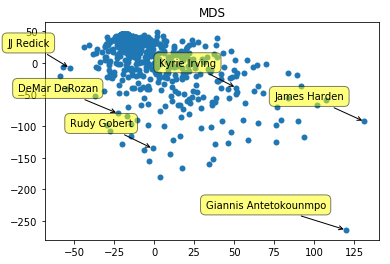

In [222]:
#Plot MDS mapping with player labels
plt.scatter(MDS_mapping[:, 0], MDS_mapping[:, 1], lw=0, label='MDS')
for label, x, y in zip(players, MDS_mapping[:, 0], MDS_mapping[:, 1]):
    if label == 'Giannis Antetokounmpo' or label == 'James Harden' or label == 'Kyrie Irving' or label == 'DeMar DeRozan' or label == 'Rudy Gobert' or label == 'JJ Redick':
        plt.annotate(label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.title('MDS')
plt.show()

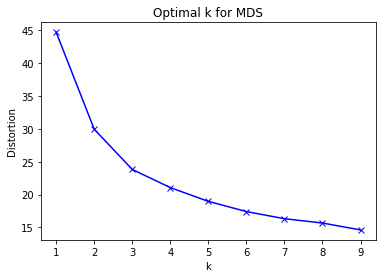

In [223]:
##Choosing the number of k clusters for MDS
distortions_mds = []
K = range(1,10)
for k in K:
    kmeans_mds = KMeans(n_clusters = k)
    kmeans_mds_model = kmeans_mds.fit(MDS_mapping)
    distortions_mds.append(sum(np.min(cdist(MDS_mapping, kmeans_mds_model.cluster_centers_, 'euclidean'), axis=1)) / MDS_mapping.shape[0])

# Plot the elbow
plt.plot(K, distortions_mds, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Optimal k for MDS')
plt.show()

In [224]:
distortions_mds

[44.72265801752558,
 29.955676316382686,
 23.823002379777016,
 21.058936270452712,
 18.96149554329294,
 17.408528587069274,
 16.322430462378076,
 15.660712783420152,
 14.613896449048397]

In [225]:
##Using the optimal number of clusters, cluster MDS
kmeans_mds = KMeans(n_clusters = 8)
kmeans_mds_model = kmeans_mds.fit(MDS_mapping)
#print("Clusters for k-means clustering on MDS: ", kmeans_mds_model.labels_)

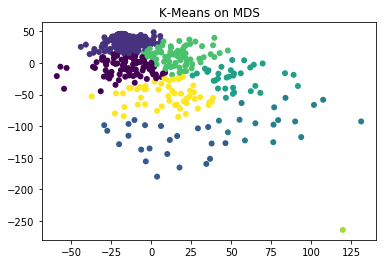

In [226]:
#Plot the clusters
plt.scatter(MDS_mapping[:, 0], MDS_mapping[:, 1], c = kmeans_mds_model.labels_, lw=0, label='MDS')
plt.title('K-Means on MDS')
plt.show()

In [227]:
#Run ISOMAP on Shots Matrix
ISOMAP = Isomap(n_components=2)
ISO_mapping = ISOMAP.fit_transform(shot_matrix)

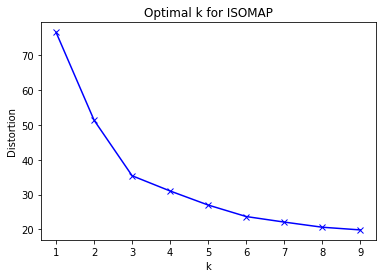

In [228]:
##Choosing the number of k clusters for ISOMAP
distortions_iso = []
K = range(1,10)
for k in K:
    kmeans_iso = KMeans(n_clusters = k)
    kmeans_iso_model = kmeans_iso.fit(ISO_mapping)
    distortions_iso.append(sum(np.min(cdist(ISO_mapping, kmeans_iso_model.cluster_centers_, 'euclidean'), axis=1)) / ISO_mapping.shape[0])

# Plot the elbow
plt.plot(K, distortions_iso, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Optimal k for ISOMAP')
plt.show()

In [229]:
distortions_iso

[76.66235394692485,
 51.38098032174726,
 35.41382441146011,
 31.033656950751176,
 26.995162694683888,
 23.69298094789788,
 22.1016105936283,
 20.622057030209717,
 19.851915341290095]

In [230]:
#Using the optimal number of clusters, cluster ISOMAP
kmeans_iso = KMeans(n_clusters = 8)
kmeans_iso_model = kmeans_iso.fit(ISO_mapping)
#print("Clusters for k-means clustering on ISOMAP: ", kmeans_iso_model.labels_)

In [231]:
#spectral_iso = SpectralClustering(n_clusters = 5, affinity = 'nearest_neighbors')
#spectral_iso_model = spectral.fit(ISO_mapping)
#print("Clusters for spectral clustering on ISOMAP: ", spectral_iso_model.labels_)

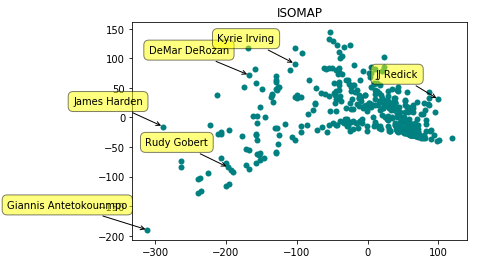

In [232]:
#Plot ISOMAP with player labels
plt.scatter(ISO_mapping[:, 0], ISO_mapping[:, 1], color = 'teal', lw=0, label='ISOMAP')
for label, x, y in zip(players, ISO_mapping[:, 0], ISO_mapping[:, 1]):
    if label == 'Giannis Antetokounmpo' or label == 'James Harden' or label == 'Kyrie Irving' or label == 'DeMar DeRozan' or label == 'Rudy Gobert' or label == 'JJ Redick':
        plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.title('ISOMAP')
plt.show()

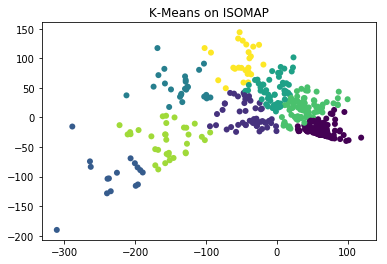

In [233]:
#Plot clusters for ISOMAP
plt.scatter(ISO_mapping[:, 0], ISO_mapping[:, 1], c = kmeans_iso_model.labels_, lw=0, label='ISOMAP')
plt.title('K-Means on ISOMAP')
plt.show()

In [234]:
tSNE = TSNE(n_components=2).fit_transform(shot_matrix)

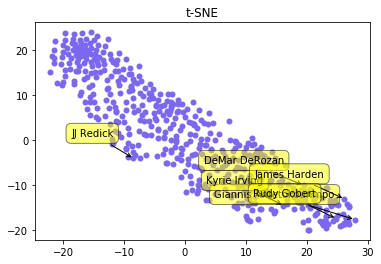

In [235]:
plt.scatter(tSNE[:, 0], tSNE[:, 1], color = 'mediumslateblue', lw=0, label='tSNE')
for label, x, y in zip(players, tSNE[:, 0], tSNE[:, 1]):
    if label == 'Giannis Antetokounmpo' or label == 'James Harden' or label == 'Kyrie Irving' or label == 'DeMar DeRozan' or label == 'Rudy Gobert' or label == 'JJ Redick':
        plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.title('t-SNE')
plt.show()

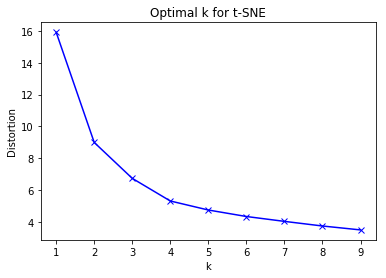

In [236]:
##Choosing the number of k clusters for ISOMAP
distortions_tsne = []
K = range(1,10)
for k in K:
    kmeans_tsne = KMeans(n_clusters = k)
    kmeans_tsne_model = kmeans_tsne.fit(tSNE)
    distortions_tsne.append(sum(np.min(cdist(tSNE, kmeans_tsne_model.cluster_centers_, 'euclidean'), axis=1)) / tSNE.shape[0])

# Plot the elbow
plt.plot(K, distortions_tsne, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Optimal k for t-SNE')
plt.show()

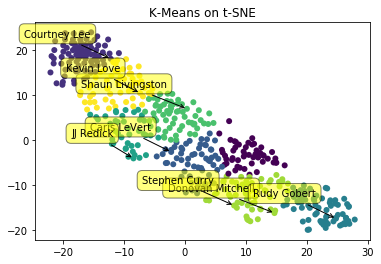

In [237]:
kmeans_tsne = KMeans(n_clusters = 8)
kmeans_tsne_model = kmeans_tsne.fit(tSNE)
plt.scatter(tSNE[:, 0], tSNE[:, 1], c = kmeans_tsne_model.labels_, lw=0, label='tSNE')
for label, x, y in zip(players, tSNE[:, 0], tSNE[:, 1]):
    if label == 'Rudy Gobert' or label == 'Stephen Curry' or label == 'JJ Redick' or label == "Caris LeVert" or label == 'Courtney Lee' or label == 'Donovan Mitchell' or label == 'Kevin Love' or label == 'Shaun Livingston':
        plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.title('K-Means on t-SNE')
plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


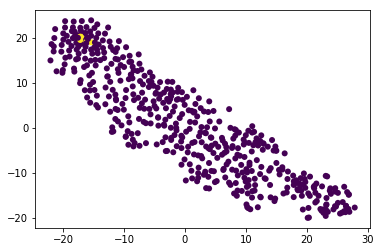

In [238]:
spectral_tsne = SpectralClustering(n_clusters = 3).fit(shot_matrix)
plt.scatter(tSNE[:, 0], tSNE[:, 1], c = spectral_tsne.labels_, lw=0, label='tSNE')
plt.show()

In [243]:
tsne_clusters = pd.DataFrame({'player': players, 'cluster' : kmeans_tsne_model.labels_})
tsne_clusters[tsne_clusters['cluster'] == 3].head()

,cluster,player
2,3,Hassan Whiteside
8,3,Giannis Antetokounmpo
9,3,Malcolm Brogdon
12,3,Karl-Anthony Towns
13,3,Derrick Rose


In [240]:
#match up the x and y indices with the indices of the shot matrix
x_array = []
y_array = []
for i in range(0,26):
    for j in range(0,24):
        y_array.append(j)
        x_array.append(i)

In [241]:
#create dataframes of all 8 concepts
first_concept = pd.DataFrame({'x_loc' : x_array, 
                              'y_loc' : y_array,
                              'first_weights' : pd.DataFrame(H).iloc[0]})
second_concept = pd.DataFrame({'x_loc' : x_array, 
                              'y_loc' : y_array,
                              'second_weights' : pd.DataFrame(H).iloc[1]})
third_concept = pd.DataFrame({'x_loc' : x_array, 
                              'y_loc' : y_array,
                              'third_weights' : pd.DataFrame(H).iloc[2]})
fourth_concept = pd.DataFrame({'x_loc' : x_array, 
                              'y_loc' : y_array,
                              'fourth_weights' : pd.DataFrame(H).iloc[3]})
fifth_concept = pd.DataFrame({'x_loc' : x_array, 
                              'y_loc' : y_array,
                              'fifth_weights' : pd.DataFrame(H).iloc[4]})
sixth_concept = pd.DataFrame({'x_loc' : x_array, 
                              'y_loc' : y_array,
                              'sixth_weights' : pd.DataFrame(H).iloc[5]})
seventh_concept = pd.DataFrame({'x_loc' : x_array, 
                              'y_loc' : y_array,
                              'seventh_weights' : pd.DataFrame(H).iloc[6]})
eighth_concept = pd.DataFrame({'x_loc' : x_array, 
                              'y_loc' : y_array,
                              'eighth_weights' : pd.DataFrame(H).iloc[7]})
#ninth_concept = pd.DataFrame({'x_loc' : x_array, 
                              #'y_loc' : y_array,
                              #'ninth_weights' : pd.DataFrame(H).iloc[8]})
#tenth_concept = pd.DataFrame({'x_loc' : x_array, 
                              #'y_loc' : y_array,
                              #'tenth_weights' : pd.DataFrame(H).iloc[9]})

In [242]:
#export concepts to be plotted in R
first_concept.to_csv('/Users/dgrubis/Desktop/second_concept.csv')
second_concept.to_csv('/Users/dgrubis/Desktop/second_concept.csv')
third_concept.to_csv('/Users/dgrubis/Desktop/third_concept.csv')
fourth_concept.to_csv('/Users/dgrubis/Desktop/fourth_concept.csv')
fifth_concept.to_csv('/Users/dgrubis/Desktop/fifth_concept.csv')
sixth_concept.to_csv('/Users/dgrubis/Desktop/sixth_concept.csv')
seventh_concept.to_csv('/Users/dgrubis/Desktop/seventh_concept.csv')
eighth_concept.to_csv('/Users/dgrubis/Desktop/eighth_concept.csv')
#ninth_concept.to_csv('/Users/dgrubis/Desktop/ninth_concept.csv')
#tenth_concept.to_csv('/Users/dgrubis/Desktop/tenth_concept.csv')